In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, ReLU, Add, Concatenate, BatchNormalization
)
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import numpy as np


In [2]:
import tensorflow as tf

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Explicitly enable GPU if needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# Verify TensorFlow is using GPU
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())

Num GPUs Available:  2
True
True


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [4]:
def preprocess_image(image):
    """
    Preprocesses the image to convert it into L (luminance) and ab (chrominance) channels
    with reduced resolution.
    Args:
        image: RGB TensorFlow image tensor.
    Returns:
        L channel (input), ab channels (ground truth).
    """
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    lab = tf.image.rgb_to_yuv(image)  # Approximation for LAB color space
    L = lab[..., :1] / 255.0  # Normalize L channel to [0, 1]
    ab = lab[..., 1:]  # ab channels as ground truth
    return L, ab

In [5]:
def load_pascal_voc(dataset_dir, batch_size):
    """
    Load and preprocess the PASCAL VOC dataset.
    """
    # Ensure the dataset directory path is correct
    dataset_dir = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"
    
    # List all JPEG images in the directory
    image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir) if fname.endswith(".jpg")]
    
    # Function to load and preprocess each image
    def load_and_preprocess(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode image as RGB
        return preprocess_image(image)  # Apply the preprocessing function
    
    # Create the TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [6]:
def color_encoder(input_shape=(256, 256, 1)):
    inp = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    return Model(inp, x, name="ColorEncoder")


In [7]:
def swin_transformer(x):
    # Replace with an actual Swin Transformer implementation if available
    return Conv2D(256, (3, 3), padding="same", activation='relu')(x)


In [8]:
def color_transformer(encoder_output, color_features):
    x = Concatenate()([encoder_output, color_features])
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = swin_transformer(x)
    return x


In [9]:
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.layers import UpSampling2D


def generator(input_shape=(256, 256, 1)):  # Adjusted input shape
    # Pretrained VGG for global features (expects 3 channels)
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))  # Adjusted resolution
    vgg.trainable = False  # Freeze VGG layers

    # Luminance input (grayscale)
    inp = Input(shape=input_shape)  # (128, 128, 1)
    
    # Replicate grayscale input to 3 channels
    replicated_inp = Concatenate(axis=-1)([inp, inp, inp])  # Shape: (128, 128, 3)

    # Pass the 3-channel version of Luminance through VGG
    vgg_out = vgg(replicated_inp)  # Output shape: (None, 4, 4, 512) for 128x128 input

    # Resize VGG output to match the size of the color encoder output
    vgg_out_resized = UpSampling2D(size=(32, 32), interpolation='bilinear')(vgg_out)  # Resize to (128, 128, 512)

    # Color Encoder
    color_enc = color_encoder(input_shape=(128, 128, 1))(inp)

    # Concatenate the resized VGG output and the color encoder output
    x = Concatenate(axis=-1)([vgg_out_resized, color_enc])  # Shape: (128, 128, 768)

    # Color Transformer
    x = color_transformer(x, color_enc)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation='relu')(x)
    output = Conv2D(2, (3, 3), padding="same", activation="tanh")(x)  # Output ab channels

    return Model(inp, output, name="Generator")





In [10]:
def discriminator(input_shape=(256, 256, 3)):
    inp = Input(shape=input_shape)
    x = Conv2D(64, (4, 4), strides=2, padding="same", activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(128, (4, 4), strides=2, padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (4, 4), strides=2, padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (4, 4), padding="same")(x)  # Single-channel output for PatchGAN
    return Model(inp, x, name="Discriminator")

In [11]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def perceptual_loss(y_true, y_pred, vgg_model):
    vgg_true = vgg_model(y_true)
    vgg_pred = vgg_model(y_pred)
    return tf.reduce_mean(tf.square(vgg_true - vgg_pred))


In [12]:
def train(generator, discriminator, dataset, epochs, batch_size):
    # Optimizers
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
    
    # VGG for perceptual loss
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    vgg_model = Model(vgg.input, vgg.layers[-2].output)  # Extract features

    # Training loop
    for epoch in range(epochs):
        for step, (L, ab) in enumerate(dataset):
            # Upsample L to 256x256
            L_upsampled = tf.image.resize(L, [256, 256])
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate fake ab channels
                fake_ab = generator(L, training=True)
                
                # Upsample fake_ab to 256x256
                fake_ab_upsampled = tf.image.resize(fake_ab, [256, 256])
                
                # Concatenate with upsampled L to form fake images
                fake_images = tf.concat([L_upsampled, fake_ab_upsampled], axis=-1)
                
                # Upsample ground truth ab
                ab_upsampled = tf.image.resize(ab, [256, 256])
                
                # Concatenate with upsampled L to form real images
                real_images = tf.concat([L_upsampled, ab_upsampled], axis=-1)

                # Resize images to 128x128 before passing to the discriminator
                real_images_resized = tf.image.resize(real_images, [128, 128])
                fake_images_resized = tf.image.resize(fake_images, [128, 128])

                # Discriminator output
                real_output = discriminator(real_images_resized, training=True)
                fake_output = discriminator(fake_images_resized, training=True)
                
                # Compute discriminator loss
                d_loss = wasserstein_loss(-tf.ones_like(real_output), real_output) + \
                         wasserstein_loss(tf.ones_like(fake_output), fake_output)
                
                # Compute generator loss
                g_loss = wasserstein_loss(-tf.ones_like(fake_output), fake_output)
                g_loss += perceptual_loss(real_images, fake_images, vgg_model)

            # Update weights
            gradients_gen = gen_tape.gradient(g_loss, generator.trainable_variables)
            gradients_disc = disc_tape.gradient(d_loss, discriminator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
            
            if step % 100 == 0:
                print(f"Epoch {epoch}, Step {step}, G Loss: {g_loss.numpy()}, D Loss: {d_loss.numpy()}")
    
    # Save the trained models
    generator.save("generator_model.h5")
    discriminator.save("discriminator_model.h5")


In [13]:
# Dataset path
dataset_path = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/JPEGImages"
# batch_size = 16      i tried to reduce the batch side because the gpu run out of memory
batch_size = 8
epochs = 50

# Load dataset
dataset = load_pascal_voc(dataset_path, batch_size) 


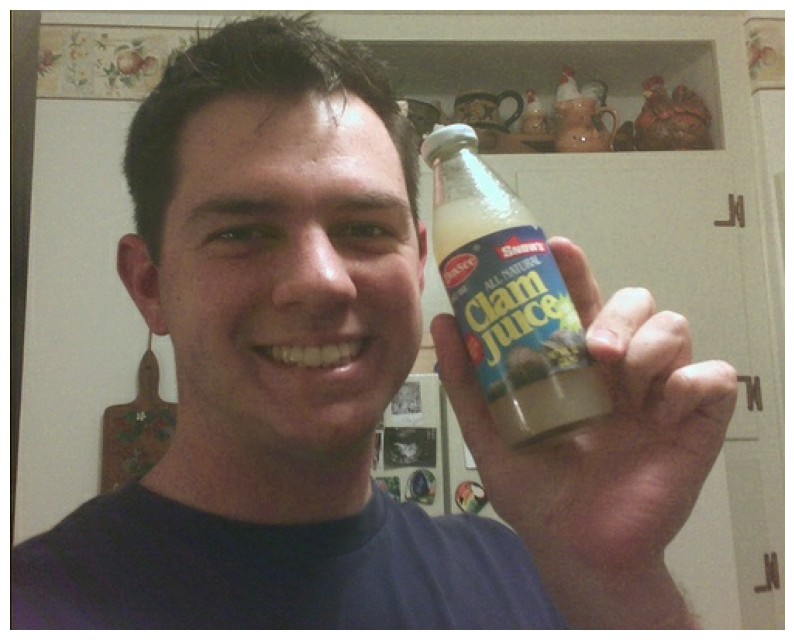

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Full path to the images
full_path = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"

# Get a list of image files
image_files = [f for f in os.listdir(full_path) if f.endswith('.jpg')]

# Read the first image
image_path = os.path.join(full_path, image_files[0])
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(image.numpy())
plt.axis('off')
plt.show()

In [15]:
# Build and train models with the modified generator
gen = generator(input_shape=(128, 128, 1))  # Input resolution changed to 128x128

disc = discriminator(input_shape=(128, 128, 3))  # Input resolution changed to 128x128




80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
train(gen, disc, dataset, epochs, batch_size)

Epoch 0, Step 0, G Loss: 1.0539450645446777, D Loss: 0.019364526495337486
Epoch 0, Step 100, G Loss: 2.411820650100708, D Loss: -5.689187049865723
